## Data preparation

In [0]:
import requests
import gzip
import zipfile
from os import path
import numpy as np
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import copy
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)

Device used:  cuda


In [0]:
# helper function to download the data and pretrained embeddings
def downloadFile(url,filepath) :
    if not path.exists(filepath) :
        with requests.get(url) as r :
            open(filepath, 'wb').write(r.content)
    if filepath[-3:]=='.gz' :
        if not path.exists(filepath[:-3]) :
            with gzip.open(filepath) as gz :
                open(filepath[:-3], 'wb').write(gz.read())
    if filepath[-4:]=='.zip' :
        if not path.exists(filepath[:-4]) :
            with zipfile.ZipFile(filepath,'r') as zp :
                zp.extractall()

In [0]:
#uncomment next one
downloadFile('https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip',
             'trainDevTestTrees_PTB.zip')
downloadFile('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz',
             'GoogleNews-vectors-negative300.bin.gz')

In [0]:
# format the data, extracting the sentence as
# well as the sentiment of the entire sentence
def ReadTextFile(filepath) :
    y = []
    X = []
    with open(filepath) as r :
        for line in r.read().split('\n') :
            #set_trace()
            if len(line)==0 :
                pass
            else :
                y.append(int(line[1]))
                X.append([word[:-1].replace(')','') for word in line.split() if word[-1]==')'])
            
    return y, X

In [0]:
# build the vocabulary of words from the training set
y,x = ReadTextFile("./trees/train.txt")
yVal, xVal = ReadTextFile("./trees/dev.txt")

In [0]:
def reduce_preprocess_embedding(x_train, x_val, embedding_dict, embedding_weights):
    """
    Removes vocabulary and corresponding embeddings of unused words which are reintroduced later at test time
    """
    w2vVocab = set(embedding_dict.keys())
    dataVocab = set()

    word2index = dict()

    for i in range(len(x_train)):
        dataVocab |= set(x_train[i])
    for i in range(len(x_val)):
        dataVocab |= set(x_val[i])
        
    print("size of vocab in dataset:", len(dataVocab))
    print("size of vocab in word2vec:", len(w2vVocab))
    # use the union between the data vocab and the word2vec vocab
    dataInW2V = dataVocab & w2vVocab
    print("size of vocab union between data and word2vec", len(dataInW2V))

    # for every word appearing in both datasets, copy the embedding into a new matrix
    weights = torch.empty((len(dataInW2V)+2, 300))
    for i, word in enumerate(dataInW2V):
        word2index[word] = i+2
        weights[i+2, :] = torch.from_numpy(embedding_weights[embedding_dict[word]])

    # add a pad token
    word2index["PAD"] = 0
    weights[0, :] = torch.zeros(1,300)
    # add an unknown word token
    word2index["UNK"] = 1
    weights[1, :] = torch.from_numpy(embedding_weights[embedding_dict["UNK"]])

    print("tokens in new embedding matrix", weights.shape[0])
    weights = weights.to(device)

    return  word2index, weights

In [0]:
# function to convert a list of words into the corresponding 
# indices using the supplied dictionary
def sentence2index(indexDict,sentence) :
    idx = []
    for word in sentence :
        try :
            idx.append(indexDict[word])
        except:
            continue
    # if no words in sentence are contained in trainable vocab, add 
    # generic unknown word vector
    if len(idx)==0:
        idx.append(indexDict["UNK"])
    return torch.tensor(idx, dtype=torch.long)

In [0]:
# function to combine data samples into a batch that the model can recieve
def pad_collate(batch):
    labels = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    # calculate the true lengths of each sequence
    phrase_lengths = torch.LongTensor([len(sentence) for sentence in text])
    # pad the sequences so that they are all of the same length to be processed
    # by the rnn as a batch
    text_pad = torch.nn.utils.rnn.pad_sequence(text, batch_first=True, padding_value=0)
    return (text_pad, phrase_lengths), labels

In [0]:
# custom dataset which processes the data using the defined functions,
# ready to be used in a dataloader
class sentenceDataset(Dataset):
    def __init__(self, text_file, indexDict):
        self.y_train, self.X_train = ReadTextFile(text_file)
        # convert the sentences of words into indexes
        self.X_train = [sentence2index(indexDict, sentence) for sentence in self.X_train]
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return [self.y_train[idx], self.X_train[idx]]

## Creating + training the model

In [0]:
class LSTMLearner(nn.Module):
    
    def __init__(self, embeddingWeights, hidden_size=300, rnn_layers=1,
                 mlp_layer_widths=100):
        super(LSTMLearner, self).__init__()
        #use the pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(embeddingWeights, freeze=True,
                                                      padding_idx=word2index["PAD"])

        # recurrent unit
        self.rnn = nn.LSTM(300, hidden_size, rnn_layers, batch_first=True, dropout=0.5)

        # fully connexted layer
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, mlp_layer_widths)
        self.fc2 = nn.Linear(mlp_layer_widths, 5)

    #pass data through all layers defined
    def forward(self, x_padded, phrase_lengths):
        x_embedded = self.embedding(x_padded)
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_embedded,
                                                           phrase_lengths,
                                                           batch_first=True, 
                                                           enforce_sorted=False)
        
        # pass through recurrent unit
        output_packed, (h_n, c_n) = self.rnn(x_packed)
        
        # since a "pack_padded" object is passed to the rnn, the output at the 
        # last timestep takes into account the different sentence lengths
        out = h_n[-1]

        # fully connected layers
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.fc2(out)

        return out

In [0]:
# function to save model parameters, which is used in early stopping to save the model
# at the epoch with best validation accuracy, before the model overfits the training data
def save_checkpoint(state, ep, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best at epoch:", ep)
    torch.save(state, filename)  # save checkpoint

In [0]:
def trainModel(embeddings_dict, embeddings_weights, epochs=25, learning_rate=0.001, 
               batch_size=512, hidden_size=300, rnn_layers=1, mlp_layer_widths=100, 
               saveBestModel=False):
  
    #create the data
    data = sentenceDataset("./trees/train.txt", embeddings_dict)
    dataLoad = DataLoader(data, batch_size=batch_size, shuffle=True,
                          collate_fn=pad_collate)
    valData = sentenceDataset("./trees/dev.txt", embeddings_dict)
    valDataLoad = DataLoader(valData, batch_size=len(valData),
                          collate_fn=pad_collate)
    
    # lists to store progress of the model at each epoch
    epoch = 0
    losses = []
    valLosses = []
    accuracy = []
    valAccuracy = []

    #copy weights so original weight matrix isn't corrupted by a training run
    weightsCopy = embeddings_weights.clone().detach()
    # create an instance of the model
    model = LSTMLearner(weightsCopy, hidden_size, rnn_layers, mlp_layer_widths)
    # move the model to the gpu
    model = model.to(device)
    
    # The question specifies using the cross entropy loss function
    loss_function = nn.CrossEntropyLoss()
    # AdamW was chosen as the optimiser as it seemed to work best 
    # with the short amount of exploration done
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad,
                                   model.parameters()), lr=learning_rate)

    for ep in range(epochs):
        total_loss = 0
        correct = 0
        # set model to train mode so dropout and batch normalisation layers work as expected
        model.train()

        for i, ((text_pad, phrase_lengths), labels) in enumerate(dataLoad):
            # move the data to the gpu
            text_pad, phrase_lengths, labels = text_pad.to(device), phrase_lengths.to(device), labels.to(device)
            model.zero_grad()
            out = model(text_pad, phrase_lengths)
            loss = loss_function(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # make predictions using the argmax of the output layer
            _, pred = out.max(1)
            correct += (pred == labels).sum().item()
            
        #after each epoch, collect statistics
        losses.append(total_loss/len(data))
        accuracy.append(100*correct/len(data))
        # statistics about the validation set
        with torch.no_grad():
            # set model to evaluation mode so dropout is no-longer used and all 
            # nodes of the model help in making the prediction
            model.eval()
            (text_pad, phrase_lengths), labels = next(iter(valDataLoad))
            text_pad, phrase_lengths, labels = text_pad.to(device), phrase_lengths.to(device), labels.to(device)
            out = model(text_pad, phrase_lengths)
            valLosses.append(loss_function(out, labels).item() / len(valData))
            _, pred = out.max(1)
            valAccuracy.append(100*(pred == labels).sum().item()/len(valData))

        #if validation improved, save new best model
        if valAccuracy[-1] == max(valAccuracy) and saveBestModel == True:
            save_checkpoint(model.state_dict(), ep)
        epoch += 1

    # calculate a fuzzy type of best validation accuracy which avoids reporting 
    # overfitting to the validation set
    top5ValAvg = np.mean(sorted(valAccuracy)[-5:])

    #clean up
    model = model.to(torch.device("cpu"))
    del text_pad, phrase_lengths, labels, out, _, pred, weightsCopy

    return model, top5ValAvg, losses, valLosses, accuracy, valAccuracy


    # Training and validation set accuracy at that epoch
    bestAccuracy = {"training set":round(accuracy[bestEpoch], 2), 
                    "validation set":round(valAccuracy[bestEpoch], 2)}

In [0]:
def plot_model(accuracy, valAccuracy, losses, valLosses):
    # epoch on which the best validation set accuracy occured
    bestEpoch = np.argmax(valAccuracy)

    # a plot of the loss as a function of epoch, with the epoch at which early 
    # stopping is performed marked with a red line
    plt.figure(1)
    plt.plot(losses, label="training set")
    plt.plot(valLosses, label="Validation set")
    plt.axvline(x=bestEpoch, color="r", label="Early stopping epoch")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.figure(2)
    plt.plot(accuracy, label="training set")
    plt.plot(valAccuracy, label="Validation set")
    plt.axvline(x=bestEpoch, color="r", label="Early stopping epoch")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

In [0]:
def test_model(embeddings_dict, embeddings_weights, accuracy, valAccuracy, 
               print_accuracies=True, is_gensim=True):
  
    with torch.no_grad():
        testData = sentenceDataset("./trees/test.txt", embeddings_dict)
        testDataLoad = DataLoader(testData, batch_size=len(testData),
                            collate_fn=pad_collate)
        ((text_pad, phrase_lengths), labels) = next(iter(testDataLoad))

        # model surgery to replace old embedding matrix with full word2vec matrix
        fullWeights = embeddings_weights
        # create PAD vector
        fullWeights[0, :] = np.zeros((1, 300))
        fullWeights = torch.FloatTensor(fullWeights)
        oldStateDict = torch.load("checkpoint.pth.tar", map_location=torch.device("cpu"))
        oldRelevantStates = {k: v for k, v in oldStateDict.items() if k != "embedding.weight"}

        model = LSTMLearner(fullWeights, hidden_size=300, rnn_layers=2, mlp_layer_widths=100)
        newStateDict = model.state_dict()
        newStateDict.update(oldRelevantStates) 
        model.load_state_dict(newStateDict)
    
        #set model to evaluation mode so dropout works as intended
        model.eval()
        out = model(text_pad, phrase_lengths)
        _, pred = out.max(1)
    
    # epoch on which the best validation set accuracy occured
    bestEpoch = np.argmax(valAccuracy)
    
    # Training and validation set accuracy at that epoch
    bestAccuracy = {"training set":round(accuracy[bestEpoch], 2), 
                    "validation set":round(valAccuracy[bestEpoch], 2)}

    bestAccuracy["test set"] = round(100*(pred == labels).sum().item()/len(testData), 2)
    
    if print_accuracies:
        for k, v in bestAccuracy.items():
            print(k, ": ", v)
    
    return bestAccuracy

## Example: load and test embedding performance on SST

Given an embedding a) dictionary of word to indices and b) embedding weights, we can calculate the accuracy on the SST test set

TO-DO: wrap this all neatly into a class but below is enough to show it works

In [0]:
W2Vmodel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                             binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
W2V_dict = {token: token_index for token_index, token in enumerate(W2Vmodel.index2word)} 
W2V_weights = W2Vmodel.vectors

In [0]:
word2index, weights = reduce_preprocess_embedding(x, xVal, fullDictW2I, W2V_weights, is_gensim=False)

size of vocab in dataset: 19463
size of vocab in word2vec: 3000000
size of vocab union between data and word2vec 17128
tokens in new embedding matrix 17130


In [0]:
model, top5ValAvg, losses, valLosses, accuracy, valAccuracy = trainModel(word2index, weights, epochs= 70, learning_rate=0.003, batch_size=512, rnn_layers=2, mlp_layer_widths=100, saveBestModel=True)

=> Saving a new best at epoch: 0
=> Saving a new best at epoch: 1
=> Saving a new best at epoch: 2
=> Saving a new best at epoch: 4
=> Saving a new best at epoch: 5
=> Saving a new best at epoch: 7
=> Saving a new best at epoch: 9


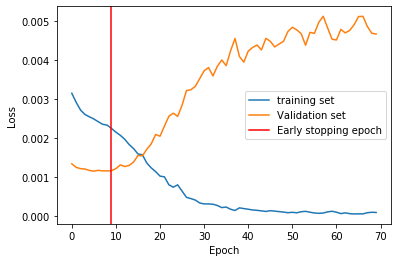

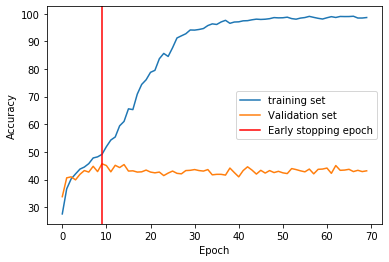

In [0]:
plot_model(accuracy, valAccuracy, losses, valLosses)

In [0]:
test_model(W2V_dict, W2V_weights, accuracy, valAccuracy, print_accuracies=True)

training set :  49.11
validation set :  45.69
test set :  45.29


{'test set': 45.29, 'training set': 49.11, 'validation set': 45.69}

# Useful links:

https://stackoverflow.com/questions/49710537/pytorch-gensim-how-to-load-pre-trained-word-embeddings
https://discuss.pytorch.org/t/structure-of-weight-matrix-in-torch-nn-embedding-layer/19121
